In [1]:
import os
import re
import string
import pandas as pd
import numpy as np
import statistics
import itertools
import time
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

from io import StringIO
from skimage import io
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Lambda, Resize, Compose, ToPILImage, Normalize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

In [4]:
DIR = '../my_code/dataset/'

TRAIN_CSV = os.path.join(DIR, "train.csv")
TEST_CSV = os.path.join(DIR, "test.csv")
IMAGES_DIR = os.path.join(DIR, "data")

# Data Read

In [5]:
class Dataset(Dataset):
	'''
	The Dataset Class, child of torch.utils.data.Dataset.

	Attributes:
	csv_file (str): A string representation of the file directory to the csv data file.
	image_dir (str): A string representation of the file directory to the images data file.
	'''
	
	def __init__(self, csv_file, image_dir, transform=None, target_transform=None, has_labels = True):
		self.image_dir = image_dir
		self.transform = transform
		self.target_transform = target_transform
		self.has_labels = has_labels
		
		with open(csv_file) as file:
			lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
			self.dataframe = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
				

	def __len__(self):
		'''
		Returns the length of the dataframe representation of the csv component of the dataset.
		'''
		return self.dataframe.shape[0]
	
	def __getitem__(self, idx):
		'''
		Reads the data from the dataframe then outputs the observation's image tensor, OHE label tensor (if there are labels present), ImageID string and caption string in a tuple form.
	  	'''
		
		if torch.is_tensor(idx):
			idx = idx.tolist()
			
		img_path = os.path.join(self.image_dir, 
								self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')])
		
		img = io.imread(img_path)

		img_id = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')]
		caption = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Caption')]

		if self.has_labels:
			labels = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Labels')]
			labels = labels.split(' ') # converts the string into an iterable Python list
			labels = [int(x) for x in labels] 
			if self.target_transform:
				labels = self.target_transform(labels)
			if self.transform:
				img = self.transform(img)

			sample = (img, labels, img_id, caption)
		  
		else:
			if self.transform:
				img = self.transform(img)          
			sample = (img, img_id, caption)
			
		return sample
	
	
NUM_LABELS = 19
BATCH_SIZE = 1

transforms = Compose([
	ToTensor(),
])

train_dataset_check = Dataset(
	csv_file = TRAIN_CSV,
	image_dir = IMAGES_DIR,
	transform = transforms,
	target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
	has_labels = True,
)

In [6]:
def image_stats(checking_dataloader):
	'''
	A function to calculate the channel means and standard deviations of the image input in a training dataset.
	Sums the channel means & squared means per image, then calculates the overall mean and standard deviation by taking the first moment (mean) and square root of the second moment (variance).
	'''

	sum_channels, sumsq_channels, n_batches = 0, 0, 0

	for step, (x, _, _, _ ) in enumerate(checking_dataloader):
		sum_channels += torch.mean(x, dim = [0, 2, 3])
		sumsq_channels += torch.mean(x**2 , dim = [0, 2, 3])
		n_batches += 1

	means = sum_channels/n_batches
	stdevs = (sumsq_channels/n_batches - means**2)**0.5

	return means, stdevs

In [7]:
train_dataloader_check = DataLoader(train_dataset_check, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
means, stdevs = image_stats(train_dataloader_check)
print(f'Mean is: {means} \n Standard Deviation is: {stdevs}')

Mean is: tensor([0.4638, 0.4490, 0.4222]) 
 Standard Deviation is: tensor([0.2724, 0.2698, 0.2848])


## Sanity check image sizes - create get_image_size function

In [9]:
def get_image_sizes(checking_dataloader):
	'''
	Obtains the heights and widths of the images within the supplied dataset.
	'''
	
	heights, widths = [], []

	for step, (img, _, _, _) in enumerate(checking_dataloader):
		heights.append(img.size()[2])
		widths.append(img.size()[3])

	return heights, widths

In [10]:
heights, widths = get_image_sizes(train_dataloader_check)

print(f'Median height is: {statistics.median(heights)}')
print(f'Mean height is: {statistics.mean(heights)}')
print(f'Median width is: {statistics.median(widths)}')
print(f'Mean width is: {statistics.mean(widths)}')

Median height is: 240.0
Mean height is: 240.5502066942259
Median width is: 320.0
Mean width is: 289.9553940525403


### Creating Train/Test/Validation Datasets and Dataloaders

In [11]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 50
RESIZE_SIZE = (299, 299)
CROP_SIZE = 224 # Seems to be the standard image size used (224)
TRAIN_VAL_PROP = 0.75
SEED = 5329

transforms = Compose([
	ToTensor(),
	Normalize(mean = means, std = stdevs),
	Resize(RESIZE_SIZE),
	RandomHorizontalFlip(),
	RandomVerticalFlip(),
	RandomCrop(CROP_SIZE)
])

# The main dataset available with labels
main_dataset = Dataset(csv_file = TRAIN_CSV,
								 image_dir = IMAGES_DIR,
								 transform = transforms,
								 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
								 has_labels = True
								 )

# Need to further split it up
train_dataset, val_dataset = random_split(main_dataset, 
										  [int(round(TRAIN_VAL_PROP * len(main_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(main_dataset)))], 
										  generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = Dataset(csv_file = TEST_CSV,
								 image_dir = IMAGES_DIR,
								transform = transforms,
								 has_labels = False)

main_dataloader = DataLoader(main_dataset, batch_size = BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Plots

In [12]:
def encode_outputs(output, threshold):
	''' 
	A function to transform sigmoid outputs to one-hot encoded representations, based on a threshold value which deems the sigmoid output to be positive.
	Creates a numpy array filled with zeros per observation, transforms this to a list and appends an index with 1s if the sigmoid output of the index is greater than the threshold then appends this observation to the encoded_outputs list containing all observations.
	
	Parameters:
	output (torch.Tensor): A torch tensor of model output/predictions, calculated on a dataset with a batch size of 1.
	threshold (float): The desired probability threshold to consider a sigmoid output as a positive classification.

	Returns:
	encoded_outputs (list(list(int))): A list per observation containing a list of one-hot encoded predictions as integers with length 19.
	'''

	encoded_outputs = []
	for i in range(len(output)):
		encoded_output = np.zeros(19).tolist()
		for j in range(len(output[i][0])):
			encoded_output[j] = 1 if output[i][0][j].item() >= threshold else 0
		encoded_outputs.append(encoded_output)
	return encoded_outputs

def decode_labels(labels, threshold):
	'''
	A function to transform sigmoid outputs or OHE predictions to a list of numeric labels.
	Creates an empty list for an individual observation, appends with the value of the index + 1 which has the prediction greater than the threshold and aggregates in the decoded_labels list for all observations.

	Parameters:
	labels (list(torch.Tensor)): A list per observation of the one-hot encoded labels in a torch.Tensor.
	threshold (float): The desired probability threshold to consider a sigmoid output as a positive classification.

	Returns:
	decoded_labels (list(list(str))): A list for each observation containing a list of the labels as strings.
	'''

	decoded_labels = []
	for i in range(len(labels)):
		decoded_label = []
		for j in range(len(labels[i][0])):  
			if labels[i][0][j].item() >= threshold:
				decoded_label.append(j + 1)
		decoded_labels.append(decoded_label)
	return decoded_labels

In [13]:
def show_img(dataset):
	'''
	A function to show a 2 x 3 plot of 6 random images and display the one-hot encoded labels above it.

	Parameters:
	dataset (AssignmentDataset): The dataset containing the desired set of images for which samples are to be plotted.

	Returns:
	None 
	'''

	loader = DataLoader(train_dataset, batch_size = 6, shuffle = True)
	batch = next(iter(loader))
	images, labels,_,_ = batch

	grid = torchvision.utils.make_grid(images, nrow = 3)
	plt.figure(figsize = (12, 12))
	plt.imshow(np.transpose(grid, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


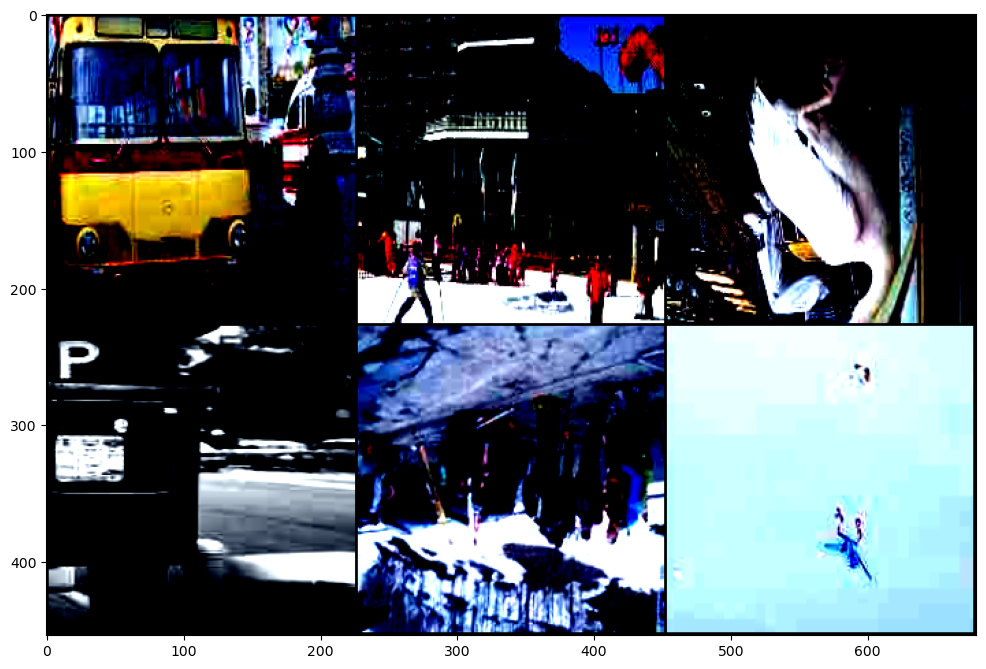

In [14]:
show_img(train_dataloader)

In [15]:
# Generate mapping dictionary between alphabet combination to Numpy array index
alphabet_combinations = {'1': string.ascii_lowercase, '2':string.ascii_lowercase, '3': string.ascii_lowercase}
alphabet_mapping = {}
array_index = 0

for combo in itertools.product(*[alphabet_combinations[k] for k in sorted(alphabet_combinations.keys())]):
	letter_combinations = ''.join(combo)
	alphabet_mapping[letter_combinations] = array_index
	array_index += 1


def encode_captions(captions):
	'''
	Transforms a list/tuple of N captions, into a N x NUM_LABELS size Torch tensor.

	Parameters:
	captions (list or tuple): A list or data structure containing strings of captions.

	Returns:
	word_encoding_array (torch.Tensor): A torch.Tensor containing 3-letter encoded captions for each image.
	'''

	# Create an empty Numpy 2D array of size (N x NUM_LABELS)
	word_encoding_array = np.zeros((len(captions), len(alphabet_mapping)))

	# Iterate over the captions
	for caption_num, caption in enumerate(captions):

		# Extract the alphabet characters
		split_text = [x for x in caption.lower() if x in string.ascii_lowercase]

		for idx in range(len(split_text)):
			if idx+3 > len(split_text):
				break

			combination = (''.join(split_text[idx:idx+3]))
			# Perform a lookup on which index it should do a +1
			array_idx = alphabet_mapping[combination]
			# Increase the combination count for the array
			word_encoding_array[caption_num][array_idx] += 1

	# Convert numpy array to Torch tensor
	word_encoding_array = torch.from_numpy(word_encoding_array).to(device)

	return word_encoding_array

In [16]:
def encode_outputs(output, threshold):
	''' 
	A function to transform sigmoid outputs to one-hot encoded representations, based on a threshold value which deems the sigmoid output to be positive.
	Creates a numpy array filled with zeros per observation, transforms this to a list and appends an index with 1s if the sigmoid output of the index is greater than the threshold then appends this observation to the encoded_outputs list containing all observations.
	
	Parameters:
	output (torch.Tensor): A torch tensor of model output/predictions, calculated on a dataset with a batch size of 1.
	threshold (float): The desired probability threshold to consider a sigmoid output as a positive classification.

	Returns:
	encoded_outputs (list(list(int))): A list per observation containing a list of one-hot encoded predictions as integers with length 19.
	'''

	encoded_outputs = []
	for i in range(len(output)):
		encoded_output = np.zeros(19).tolist()
		for j in range(len(output[i][0])):
			encoded_output[j] = 1 if output[i][0][j].item() >= threshold else 0
		encoded_outputs.append(encoded_output)
	return encoded_outputs

def decode_labels(labels, threshold):
	'''
	A function to transform sigmoid outputs or OHE predictions to a list of numeric labels.
	Creates an empty list for an individual observation, appends with the value of the index + 1 which has the prediction greater than the threshold and aggregates in the decoded_labels list for all observations.

	Parameters:
	labels (list(torch.Tensor)): A list per observation of the one-hot encoded labels in a torch.Tensor.
	threshold (float): The desired probability threshold to consider a sigmoid output as a positive classification.

	Returns:
	decoded_labels (list(list(str))): A list for each observation containing a list of the labels as strings.
	'''

	decoded_labels = []
	for i in range(len(labels)):
		decoded_label = []
		for j in range(len(labels[i][0])):  
			if labels[i][0][j].item() >= threshold:
				decoded_label.append(j + 1)
		decoded_labels.append(decoded_label)
	return decoded_labels

## Training loop funciton

In [17]:
import torch.optim.lr_scheduler as lr_scheduler
def initialize_model(num_labels):
	model = models.resnet50(pretrained=True)
	num_features = model.fc.in_features
	model.fc = nn.Sequential(
		nn.Linear(num_features, num_labels),
		nn.Sigmoid()
	)
	return model

model = initialize_model(19)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Reduces the learning rate every 7 epochs

criterion = nn.BCELoss()   

def validate_model(model, dataloader, threshold=0.5):
	total_preds, total_labels = [], []
	with torch.no_grad():
		for inputs, labels, _, _ in dataloader:
			outputs = model(inputs)
			predicted_labels = (outputs > threshold).float()
			total_preds.append(predicted_labels)
			total_labels.append(labels)

	return compute_f1_score(torch.cat(total_labels), torch.cat(total_preds))

def find_optimal_threshold(model, dataloader):
	thresholds = torch.arange(0.1, 0.9, 0.1)
	f1_scores = []
	for threshold in thresholds:
		f1_scores.append(validate_model(model, dataloader, threshold))
	optimal_threshold = thresholds[torch.argmax(torch.tensor(f1_scores))]
	print(f"Optimal threshold found: {optimal_threshold}")
	return optimal_threshold

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=25):
	for epoch in range(num_epochs):
		model.train()
		running_loss = 0.0
		for inputs, labels, _, _ in train_dataloader:
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels.float())
			loss.backward()
			optimizer.step()
			running_loss += loss.item() * inputs.size(0)
		scheduler.step()

		epoch_loss = running_loss / len(train_dataloader.dataset)
		print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

		model.eval()
		if epoch == num_epochs - 1:  # Find optimal threshold only at the last epoch
			optimal_threshold = find_optimal_threshold(model, val_dataloader)
			print(f'Validation F1 Score at optimal threshold {optimal_threshold}: {validate_model(model, val_dataloader, optimal_threshold):.4f}')
		else:
			print(f'Validation F1 Score at threshold 0.5: {validate_model(model, val_dataloader):.4f}')

		return train_batch_losses, val_batch_losses, val_f1_scores

def train_loop(dataloader, val_dataloader, model, loss_fn, optimizer, test_threshold=None, with_captions=False):
	train_batch_losses = []
	val_batch_losses = []
	val_f1_scores = []

	size = len(dataloader.dataset)
	model.train()

	for batch, (X, y, _, captions) in enumerate(dataloader):
		X, y = X.to(device), y.to(device)

		if with_captions:
			
			word_encoding_array = encode_captions(captions)
			pred = model(X, word_encoding_array)
		else:
			pred = model(X)
		
		if type(model) == torchvision.models.inception.Inception3:
			loss = loss_fn(pred.logits, y.type(torch.float))
		else:
			loss = loss_fn(pred, y.type(torch.float))

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % EVAL_EVERY == 0:
			train_batch_losses.append(loss.item())
			current = batch * len(X)
			print(f'Loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]')

			if test_threshold is not None:
				model.eval()
				with torch.no_grad():
					for X_val, y_val, _, captions_val in val_dataloader:
						X_val, y_val = X_val.to(device), y_val.to(device)
						if with_captions:
							word_encoding_array_val = encode_captions(captions_val)
							pred_val = model(X_val, word_encoding_array_val)
						else:
							pred_val = model(X_val)
						
						val_loss = loss_fn(pred_val, y_val.type(torch.float))
						val_batch_losses.append(val_loss.item())
						# Assuming encode_outputs is a function to apply threshold
						pred_labels = (pred_val > test_threshold).float()
						f1 = f1_score(y_val.cpu().numpy(), pred_labels.cpu().numpy(), average='macro')
						val_f1_scores.append(f1)

				model.train()
				print(f'Validation Loss: {val_loss.item():>7f}, F1 Score: {f1:>7f}')

	return train_batch_losses, val_batch_losses, val_f1_scores

/home/reynardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/reynardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:


def output_to_submission(test_dataloader, model, threshold=0.5, with_captions=False):
	'''
	Process test data through the model and format outputs for submission.

	Parameters:
	- test_dataloader (DataLoader): DataLoader for the test dataset, expected to yield tuples of (images, _, captions).
	- model (torch.nn.Module): The trained model to use for predictions.
	- threshold (float): Threshold for converting model output probabilities to binary labels.
	- with_captions (bool): Indicates if captions are used alongside images for prediction.

	Returns:
	- text_output (list): List of lists, each containing ImageID and space-delimited predicted labels.
	- dataframe_output (DataFrame): DataFrame with ImageID and corresponding predicted labels.
	'''
	model.eval()  # Set the model to evaluation mode
	device = next(model.parameters()).device  # Get the device model is on
	predictions = []
	image_ids = []

	with torch.no_grad():  # No need to track gradients
		for batch in test_dataloader:
			images, _, captions = batch
			images = images.to(device)  # Ensure images are on the same device as model

			if with_captions:
				captions = encode_captions(captions)  # Assuming encode_captions is a defined function
				captions = captions.to(device)
				outputs = model(images, captions)
			else:
				outputs = model(images)

			outputs = torch.sigmoid(outputs)  # Apply sigmoid to convert logits to probabilities
			predicted_labels = (outputs > threshold).int()  # Convert probabilities to binary labels
			predictions.extend(predicted_labels.cpu().numpy())  # Store predictions
			image_ids.extend(test_dataloader.dataset.dataframe['ImageID'].iloc[batch[0].indices].tolist())

	# Format predictions into the required submission format
	formatted_predictions = [' '.join(str(label_idx + 1) for label_idx, label in enumerate(pred) if label == 1) for pred in predictions]
	text_output = [['ImageID', 'Labels']] + list(zip(image_ids, formatted_predictions))
	dataframe_output = pd.DataFrame(text_output[1:], columns=text_output[0])

	return text_output, dataframe_output


## CNN

In [19]:
class BasicCNN(nn.Module):
	'''
	Simplified BasicCNN model for image classification with basic convolutional layers, 
	followed by fully connected layers, incorporating dropout for regularization.
	'''
	def __init__(self):
		super(BasicCNN, self).__init__()

		# Define convolutional layers with modular approach
		self.features = nn.Sequential(
			nn.Conv2d(3, 32, kernel_size=10, stride=1, padding=1),
			nn.LeakyReLU(),
			nn.MaxPool2d(kernel_size=2),
			nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
			nn.LeakyReLU(),
			nn.MaxPool2d(kernel_size=2),
			nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
			nn.LeakyReLU(),
			nn.MaxPool2d(kernel_size=2),
			nn.Dropout2d(0.25)
		)
		
		# Linear layers might need adjustment depending on the input image size
		self.classifier = nn.Sequential(
			nn.Linear(128 * 3 * 3, 128),  # Adjust the input features according to the output of the last conv layer
			nn.ReLU(),
			nn.Dropout(1/3),
			nn.Linear(128, 256),
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(256, 19)
		)

	def forward(self, x):
		'''
		Forward pass of the network, applying convolutional blocks followed by classification blocks.
		
		Parameters:
		x (torch.Tensor): Input tensor of shape (N, 3, H, W) where N is the batch size.

		Returns:
		logits (torch.Tensor): Output tensor of logits for each class.
		'''
		x = self.features(x)
		x = torch.flatten(x, 1)  # Flatten the output from the convolutional layers
		logits = self.classifier(x)
		return logits



In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
	def __init__(self, num_classes=10):
		super(BasicCNN, self).__init__()
		# Convolutional layers
		self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
		self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

		# Pooling layer
		self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2 and stride 2

		# Linear layers
		self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjust size according to the output of the last conv layer
		self.fc2 = nn.Linear(512, num_classes)

	def forward(self, x):
		# Apply convolutional layers with ReLU and pooling
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))

		# Flatten the layer before passing to the fully connected layers
		x = x.view(-1, 128 * 4 * 4)  # Flatten all dimensions except batch

		# Fully connected layers with ReLU activation and final layer
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x

# Create a model instance and print it
model = BasicCNN(num_classes=10)
print(model)


BasicCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [22]:
BasicCNN_model = BasicCNN().to(device)
print("Model Initialized")
print(BasicCNN_model)

Model Initialized
BasicCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [23]:

LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

# Loss function and optimizer
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(BasicCNN_model.parameters(), lr=LR)

# Lists to hold loss and F1 scores
BasicCNN_train_loss = []
BasicCNN_val_loss = []
BasicCNN_val_f1 = []

# Start timing
t0 = time.time()

# Training loop
for t in range(NUM_EPOCHS):
	print(f"-------------------------------\nEpoch {t+1}")
	#train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, BasicCNN_model, loss_fn, optimizer, test_threshold=0.5, with_captions=False)
	train_loss1, val_loss1, val_f11 = train_model(BasicCNN_model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=25)
	#BasicCNN_train_loss.extend(train_loss)
	#BasicCNN_val_loss.extend(val_loss)
	#BasicCNN_val_f1.extend(val_f1)
	BasicCNN_train_loss.extend(train_loss1)
	BasicCNN_val_loss.extend(val_loss1)
	BasicCNN_val_f1.extend(val_f11)

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))


-------------------------------
Epoch 1


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

: 

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
	def __init__(self, num_classes=19):  # Default to 19 classes unless specified otherwise
		super(CustomCNN, self).__init__()
		self.features = nn.Sequential(
			nn.Conv2d(3, 32, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),
			nn.Conv2d(32, 64, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),
			nn.Conv2d(64, 128, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2)
		)
		self.classifier = nn.Sequential(
			nn.Linear(128 * 3 * 3, 512),  # Adjust the input features according to the output of the last conv layer
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(512, num_classes)  # Set the number of output features to match the number of classes
		)

	def forward(self, x):
		x = self.features(x)
		x = torch.flatten(x, 1)  # Flatten the output from the convolutional layers
		x = self.classifier(x)
		return x

# Create a model instance with 19 classes
model = CustomCNN(num_classes=19)
print(model)


100%|████████████████████████| 170498071/170498071 [00:37<00:00, 4496566.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


TypeError: BasicCNN.__init__() got an unexpected keyword argument 'input_size'